In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import tensorflow
import keras
from keras.utils import image_dataset
from keras.applications import imagenet_utils
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from keras.layers import *
from keras import Sequential
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.losses import SparseCategoricalCrossentropy
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input as ppi_vgg
from keras.models import Model
from matplotlib import image as mpimg
import pickle

In [ ]:
data = pd.read_csv('./data/birds.csv')

## set directory for filepaths
base_dir= './data/'
data = data.assign(full_path = base_dir+data.filepaths)

birds=['COLLARED CRESCENTCHEST','GOLDEN PARAKEET','CRAB PLOVER','CRESTED OROPENDOLA','INLAND DOTTEREL','ABBOTTS BOOBY',
       'RUFOUS TREPE','RED FACED WARBLER','BARN SWALLOW','SCARLET CROWNED FRUIT DOVE','RUDY KINGFISHER','RED BELLIED PITTA',
       'YELLOW BREASTED CHAT','ANIANIAU','GREY CUCKOOSHRIKE']

mapper={}
for idx, bird in enumerate(birds):
    mapper[bird] = idx
    if idx == 0:
        bdf = pd.DataFrame(data[(data.labels == bird)])
    else:
        bdf = pd.concat([bdf,data[(data.labels == bird)]],axis=0)

## assign a new column with labels (0-14)
bdf = bdf.assign(new_labels = bdf.labels.apply(lambda x: mapper[x]))

## adds directory path to column train/test/split
bdf['dir'] = bdf.filepaths.str.split("/").apply(lambda x: '/'+x[0]+'/'+x[1])

## removes existing bird_set directory
try:
    shutil.rmtree('./data/bird_set')
except FileNotFoundError:
    pass

## populates new bird_set directory with train/test/valid
for folder in bdf.dir.unique():
    src = './data'+folder+'/'
    dest = './data/bird_set'+folder+'/'
    shutil.copytree(src,dest)

## train test val split for CNN
train = bdf[(bdf['data set'] == 'train')]
test = bdf[(bdf['data set'] == 'test')]
valid = bdf[(bdf['data set'] == 'valid')]

Xtrain = np.array([plt.imread(x) for x in train.full_path])
ytrain = train.new_labels

Xtest = np.array([plt.imread(x) for x in test.full_path])
ytest = test.new_labels

Xvalid = np.array([plt.imread(x) for x in valid.full_path])
yvalid = valid.new_labels


In [65]:
bdf.sample(3)

,class id,filepaths,labels,data set,scientific name,full_path,new_labels,dir
10039,63.0,train/BARN SWALLOW/045.jpg,BARN SWALLOW,train,HIRUNDO RUSTICA,./data/train/BARN SWALLOW/045.jpg,8,/train/BARN SWALLOW
68183,426.0,train/RUFOUS TREPE/126.jpg,RUFOUS TREPE,train,DENDROCITTA VAGABUNDA,./data/train/RUFOUS TREPE/126.jpg,6,/train/RUFOUS TREPE
67819,424.0,train/RUDY KINGFISHER/131.jpg,RUDY KINGFISHER,train,HALCYON COROMANDA,./data/train/RUDY KINGFISHER/131.jpg,10,/train/RUDY KINGFISHER


In [44]:
## basic CNN

neurons = (32,64,128,256,512)
conv_window = (3,3)
max_pooling = (2,2)
batch = 64
ep = 10
learn_rate = 0.001
mp_strides =(3,3)

cnnmodel = keras.Sequential()

cnnmodel.add(Conv2D(neurons[0],conv_window,input_shape=(Xtrain[0].shape),padding='same',activation='relu'))
cnnmodel.add(BatchNormalizationV2())
cnnmodel.add(MaxPooling2D(max_pooling,strides=mp_strides,padding='same'))
cnnmodel.add(Dropout(.35))

cnnmodel.add(Conv2D(neurons[1],conv_window,activation='relu'))
cnnmodel.add(MaxPooling2D(max_pooling,strides=mp_strides,padding='same'))
cnnmodel.add(BatchNormalizationV2())
cnnmodel.add(Dropout(.35))

cnnmodel.add(Conv2D(neurons[2],conv_window,activation='relu'))
cnnmodel.add(MaxPooling2D(max_pooling,strides=mp_strides,padding='same'))
cnnmodel.add(BatchNormalizationV2())
cnnmodel.add(Dropout(.35))

cnnmodel.add(Flatten())
cnnmodel.add(Dense(neurons[3],activation='relu'))
cnnmodel.add(Dense(neurons[4],activation='relu'))
cnnmodel.add(Dense(15,activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=learn_rate)
cnnmodel.compile(loss=SparseCategoricalCrossentropy(),optimizer=opt,metrics=['accuracy'])
cnnmodel.fit(Xtrain,ytrain,batch_size=batch,epochs=ep)

##get highest classified probability
cnnpreds = [np.argmax(x) for x in model.predict(Xtest)]

## print actual accuracy score
print(f'Accuracy on test data:{accuracy_score(ytest,cnnpreds)}')

Epoch 1/10
40/40 [==============================] - 25s 592ms/step - loss: 1.7423 - accuracy: 0.4840
Epoch 2/10
40/40 [==============================] - 23s 585ms/step - loss: 0.7390 - accuracy: 0.7596
Epoch 3/10
40/40 [==============================] - 23s 582ms/step - loss: 0.4713 - accuracy: 0.8490
Epoch 4/10
40/40 [==============================] - 24s 595ms/step - loss: 0.2918 - accuracy: 0.9014
Epoch 5/10
40/40 [==============================] - 23s 584ms/step - loss: 0.2105 - accuracy: 0.9257
Epoch 6/10
40/40 [==============================] - 24s 604ms/step - loss: 0.1783 - accuracy: 0.9441
Epoch 7/10
40/40 [==============================] - 24s 604ms/step - loss: 0.1241 - accuracy: 0.9637
Epoch 8/10
40/40 [==============================] - 24s 609ms/step - loss: 0.0660 - accuracy: 0.9792
Epoch 9/10
40/40 [==============================] - 24s 602ms/step - loss: 0.0888 - accuracy: 0.9708
Epoch 10/10
3/3 [==============================] - 0s 54ms/step
Accuracy on test data:0.826

In [89]:
# ## testing saved models..
# test_cnn = keras.models.load_model('./models/CNN.h5')
# test_preds = [np.argmax(x) for x in test_cnn.predict(Xtest)]
# accuracy_score(test_preds,ytest)

In [52]:
## classification report
print(classification_report(ytest,cnnpreds))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.60      0.75         5
           4       0.44      0.80      0.57         5
           5       1.00      0.40      0.57         5
           6       0.75      0.60      0.67         5
           7       1.00      1.00      1.00         5
           8       0.71      1.00      0.83         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.57      0.80      0.67         5
          13       1.00      1.00      1.00         5
          14       0.80      0.80      0.80         5

    accuracy                           0.83        75
   macro avg       0.87      0.83      0.83        75
weighted avg       0.87   

In [34]:
## efficientNET CNN

train_dir='./data/bird_set/train/'
test_dir='./data/bird_set/test/'
valid_dir='./data/bird_set/valid/'

## hyper params
BATCH_SIZE=32
STEPS = 76
NEURONS=(512,512)
LRATE=.001

## instantiate data generator with ppi_vgg preprocessing
data_generator = ImageDataGenerator(preprocessing_function=ppi_vgg)

## preprocess train data
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    classes=birds,
    class_mode='categorical',
    shuffle=True)

## preprocessed test data
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    classes=birds,
    class_mode='categorical',
    shuffle = False)

## preprocessed valid data
val_generator = data_generator.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    classes=birds,
    class_mode='categorical',
    shuffle=True)

## instantiate EfficientNet model with pretrained imagenet model
efn = EfficientNetB0(include_top=False, weights='imagenet', drop_connect_rate=.1,input_shape=(224,224,3))

## freeze imagenet layers
for layer in efn.layers:
    layer.trainable = False

## instantiate model
efmodel = Sequential()
efmodel.add(BatchNormalization())
efmodel.add(efn)
efmodel.add(GlobalAveragePooling2D())
efmodel.add(BatchNormalization())
efmodel.add(Dense(NEURONS[0],activation='relu'))
efmodel.add(Dense(NEURONS[1],activation='relu'))
efmodel.add(Dense(15, activation='softmax'))

# model.summary()
efmodel.compile(optimizer=Adam(learning_rate=LRATE),loss='categorical_crossentropy',metrics=['accuracy'])

efhistory = efmodel.fit(train_generator,epochs=10,steps_per_epoch=STEPS,verbose=1)

Found 2504 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Epoch 1/10
76/76 [==============================] - 119s 1s/step - loss: 2.2883 - accuracy: 0.2936
Epoch 2/10
76/76 [==============================] - 108s 1s/step - loss: 1.7920 - accuracy: 0.4273
Epoch 3/10
76/76 [==============================] - 106s 1s/step - loss: 1.5207 - accuracy: 0.5141
Epoch 4/10
76/76 [==============================] - 106s 1s/step - loss: 1.3432 - accuracy: 0.5615
Epoch 5/10
76/76 [==============================] - 111s 1s/step - loss: 1.1791 - accuracy: 0.6164
Epoch 6/10
76/76 [==============================] - 110s 1s/step - loss: 1.0243 - accuracy: 0.6624
Epoch 7/10
76/76 [==============================] - 111s 1s/step - loss: 0.9199 - accuracy: 0.6998
Epoch 8/10
76/76 [==============================] - 108s 1s/step - loss: 0.8381 - accuracy: 0.7259
Epoch 9/10
76/76 [==============================] - 107s 1s/step - loss: 0.7546 - a

In [95]:
## unable to save model due to bug in tensorflow version 2.10.0
## efmodel.save('./models/efnmodel.h5')
tensorflow.__version__

'2.10.0'

In [79]:
print(f'Number of trainable params: {efmodel.count_params()}')

Number of trainable params: 4980926


In [62]:
## testing accuracy
predictions = [np.argmax(x) for x in efmodel.predict(test_generator)]
ytest = test_generator.labels
print(f'Accuracy on testing set: {round(accuracy_score(ytest,predictions),4)}')

3/3 [==============================] - 1s 233ms/step
Accuracy on testing set: 0.7867


In [38]:
## classification report
predictions = efmodel.predict(test_generator)
y_true = test_generator.labels
y_pred = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

3/3 [==============================] - 3s 250ms/step
                            precision    recall  f1-score   support

    COLLARED CRESCENTCHEST       1.00      0.80      0.89         5
           GOLDEN PARAKEET       1.00      1.00      1.00         5
               CRAB PLOVER       1.00      1.00      1.00         5
        CRESTED OROPENDOLA       1.00      0.80      0.89         5
           INLAND DOTTEREL       1.00      0.80      0.89         5
             ABBOTTS BOOBY       1.00      0.60      0.75         5
              RUFOUS TREPE       1.00      0.60      0.75         5
         RED FACED WARBLER       0.83      1.00      0.91         5
              BARN SWALLOW       0.80      0.80      0.80         5
SCARLET CROWNED FRUIT DOVE       0.56      1.00      0.71         5
           RUDY KINGFISHER       0.83      1.00      0.91         5
         RED BELLIED PITTA       0.80      0.80      0.80         5
      YELLOW BREASTED CHAT       0.50      0.40      0.44     

In [63]:

train_folder = './data/bird_set/train/'
test_folder = './data/bird_set/test/'
validation_folder = './data/bird_set/valid/'


train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   preprocessing_function=ppi_vgg,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale=1.0/255, 
                                        preprocessing_function=ppi_vgg,
                                        rotation_range = 20,
                                        zoom_range = 0.2,
                                        horizontal_flip = True)


train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(224, 224),
    batch_size=32,
    classes=birds,
    class_mode='categorical',
    shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_folder,
    target_size=(224, 224),
    batch_size=32,
    classes=birds,
    class_mode='categorical',
    shuffle = True)

test_datagen = ImageDataGenerator(rescale=1.0/255, preprocessing_function=ppi_vgg)
test_generator = test_datagen.flow_from_directory(
    directory=test_folder,
    target_size=(224, 224),
    batch_size=32,
    classes=birds,
    class_mode='categorical',
    shuffle = False)

Found 2504 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


We used Google Colab to run the pre-trained VGG19 model to help us boost the training time

In [64]:
# pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(15, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# transfer learning
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)


Epoch 1/10
79/79 [==============================] - 209s 3s/step - loss: 2.4580 - accuracy: 0.2408 - val_loss: 2.1307 - val_accuracy: 0.2533
Epoch 2/10
79/79 [==============================] - 194s 2s/step - loss: 1.9397 - accuracy: 0.4696 - val_loss: 1.5618 - val_accuracy: 0.6267
Epoch 3/10
79/79 [==============================] - 198s 3s/step - loss: 1.5750 - accuracy: 0.5919 - val_loss: 1.1847 - val_accuracy: 0.7467
Epoch 4/10
79/79 [==============================] - 197s 2s/step - loss: 1.3239 - accuracy: 0.6554 - val_loss: 0.9035 - val_accuracy: 0.8533
Epoch 5/10
79/79 [==============================] - 195s 2s/step - loss: 1.1222 - accuracy: 0.7157 - val_loss: 0.7509 - val_accuracy: 0.8400
Epoch 6/10
79/79 [==============================] - 191s 2s/step - loss: 0.9723 - accuracy: 0.7592 - val_loss: 0.6444 - val_accuracy: 0.8800
Epoch 7/10
79/79 [==============================] - 197s 2s/step - loss: 0.8697 - accuracy: 0.7728 - val_loss: 0.5474 - val_accuracy: 0.9067
Epoch 8/10
79

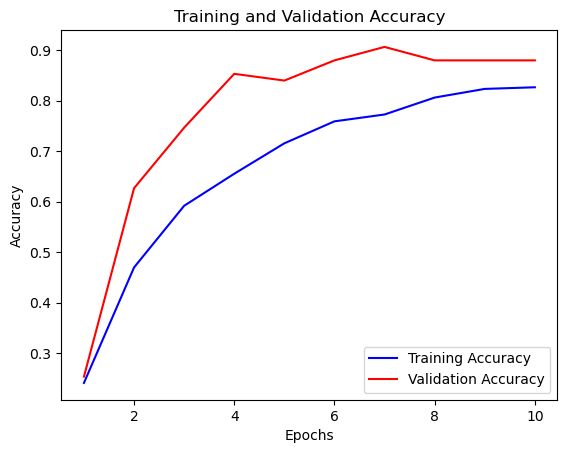

In [66]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
## loading saved model
vggmodel = tensorflow.keras.models.load_model('./models/vgg19.h5')

In [97]:
## loss and accuracy
test_loss, test_acc = vggmodel.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

3/3 [==============================] - 7s 2s/step - loss: 0.3612 - accuracy: 0.9200
Test Loss: 0.36121082305908203
Test Accuracy: 0.9200000166893005


In [98]:
## classification report
predictions = vggmodel.predict(test_generator)
y_true = test_generator.labels
y_pred = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

3/3 [==============================] - 6s 2s/step
                            precision    recall  f1-score   support

    COLLARED CRESCENTCHEST       1.00      1.00      1.00         5
           GOLDEN PARAKEET       0.62      1.00      0.77         5
               CRAB PLOVER       1.00      1.00      1.00         5
        CRESTED OROPENDOLA       0.80      0.80      0.80         5
           INLAND DOTTEREL       1.00      1.00      1.00         5
             ABBOTTS BOOBY       1.00      0.80      0.89         5
              RUFOUS TREPE       1.00      0.80      0.89         5
         RED FACED WARBLER       1.00      1.00      1.00         5
              BARN SWALLOW       0.71      1.00      0.83         5
SCARLET CROWNED FRUIT DOVE       1.00      1.00      1.00         5
           RUDY KINGFISHER       1.00      1.00      1.00         5
         RED BELLIED PITTA       1.00      1.00      1.00         5
      YELLOW BREASTED CHAT       1.00      0.60      0.75        

In [99]:
##confusion matrix
print(confusion_matrix(y_true, y_pred))

[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 4 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 4]]
